<a href="https://colab.research.google.com/github/Lenaami/AudioLabs/blob/master/AA_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install soundfile

In [0]:
import librosa
import librosa.display
import soundfile
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

import pickle
import time
import statistics

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/train.csv", delimiter=',')

In [5]:
data.head()

,fname,label
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping
1,00d77b917e241afa06f1.wav,Squeak
2,17bb93b73b8e79234cb3.wav,Electric_piano
3,7d5c7a40a936136da55e.wav,Harmonica
4,17e0ee7565a33d6c2326.wav,Snare_drum


In [0]:
labels = list(data['label'])
fnames = list(data['fname'])

In [8]:
snd, sr = soundfile.read("/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/Стрельба на улице.wav")
print(sr, snd.shape)

16000 (254225,)


Вариант 7. Mel, SVM

Размер данных: (128, 32)


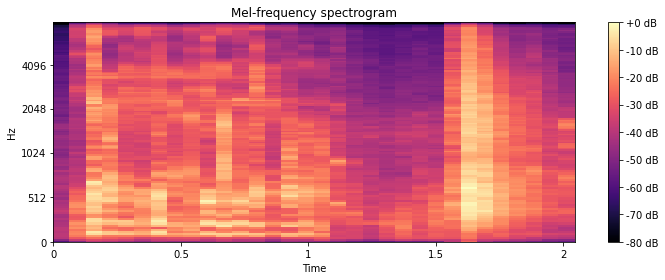

In [9]:
snd, sr = librosa.load("/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/Стрельба на улице.wav", sr=8000)
S = librosa.feature.melspectrogram(snd, sr, hop_length=4000, n_fft=8000)
print('Размер данных:', S.shape)

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

Обработка аудио

In [165]:
start_time = time.time()
X = []

for f in fnames:
    y, sr = librosa.load("/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/train/" + f, sr=8000)
    X.append(librosa.feature.melspectrogram(y, sr, hop_length=4000, n_fft=8000))

print('Сек: ', time.time() - start_time)
print('Обработано аудиофайлов:', len(X))

Сек:  2078.8852989673615
Обработано аудиофайлов: 5683


In [0]:
def save_pkl(name, data):
    with open('/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/' + name + '.pickle', 'wb') as f:
        pickle.dump(data, f)

def load_pkl(name):
    with open('/content/gdrive/My Drive/Аудиоаналитика. Лабы/Train set/' + name + '.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

In [0]:
save_pkl('X_sr8000_hl4000_nfft8000', X)

In [0]:
save_pkl('y', labels)

In [0]:
y = load_pkl('y')

In [0]:
X_load = load_pkl('X_sr8000_hl4000_nfft8000')

In [14]:
len_X = []
for x in X_load:
    len_X.append(x.shape[1])

print('Максимальная длина:', max(len_X))
print('Минимальная длина:', min(len_X))
print('Средняя длина:', np.mean(len_X))
print('Медиана:', statistics.median(len_X))
print('Мода:', statistics.mode(len_X))

max_length = max(len_X)

Максимальная длина: 61
Минимальная длина: 1
Средняя длина: 14.165757522435333
Медиана: 9
Мода: 2


In [0]:
new_size = max_length

X_re = []
for x in X_load:
    a = np.zeros(new_size * 128)
    a[:x.size] = np.reshape(x, (x.size,))  # a[:min(x.size, new_size)] = np.reshape(x, (x.size,))[:min(x.size, new_size)]  если нужный размер меньше максимального
    X_re.append(a)

Обучение классификатора

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_re, y, test_size=0.30, random_state=42)

In [17]:
model = SVC(C=100)
model.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
expected = y_train
predicted = model.predict(X_train)

print(metrics.classification_report(expected, predicted))
print('f1-score: ', metrics.f1_score(expected, predicted, average='micro'))

                       precision    recall  f1-score   support

      Acoustic_guitar       1.00      0.85      0.92       141
             Applause       0.82      0.62      0.70       139
                 Bark       0.99      0.71      0.82       113
            Bass_drum       0.99      0.94      0.97       133
Burping_or_eructation       0.96      0.32      0.49        77
                  Bus       1.00      0.44      0.61        48
                Cello       0.91      0.64      0.75       135
                Chime       1.00      0.19      0.32        53
             Clarinet       0.99      0.70      0.82       121
    Computer_keyboard       1.00      0.04      0.08        48
                Cough       0.91      0.35      0.50       115
              Cowbell       0.96      0.53      0.69        88
          Double_bass       0.92      0.56      0.70       128
 Drawer_open_or_close       1.00      0.08      0.16        71
       Electric_piano       1.00      0.98      0.99  

In [20]:
expected = y_test
predicted = model.predict(X_test)

print(metrics.classification_report(expected, predicted))
print('f1-score: ', metrics.f1_score(expected, predicted, average='micro'))

                       precision    recall  f1-score   support

      Acoustic_guitar       0.21      0.24      0.22        46
             Applause       0.22      0.41      0.29        44
                 Bark       0.00      0.00      0.00        34
            Bass_drum       0.48      0.48      0.48        48
Burping_or_eructation       0.22      0.06      0.09        36
                  Bus       0.00      0.00      0.00        16
                Cello       0.15      0.12      0.13        51
                Chime       0.00      0.00      0.00        25
             Clarinet       0.24      0.22      0.23        55
    Computer_keyboard       0.00      0.00      0.00        18
                Cough       0.00      0.00      0.00        48
              Cowbell       0.73      0.38      0.50        29
          Double_bass       0.50      0.13      0.20        63
 Drawer_open_or_close       0.00      0.00      0.00        23
       Electric_piano       0.03      0.05      0.04  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Обработка аудио:
* sample_rate=8000, мел-спектрограмма (hop_length=4000, n_fft=8000)

Классификатор:
* SVM (С=100)

При данном наборе параметров достигнут лучший результат (по сравнению с другими) на тестовой выборке - f1-score=0,13.
Результат на обучающей выборке - f1-score=0,49.